##  Проект № 5
### Служба такси.

### Дополнительный раздел. Аналитика
__По заданию: провести аналитику и построить график на тему «Как пройденное расстояние и  
количество пассажиров влияет на чаевые» в любом удобном инструменте.__

#### Предварительный этап. 
__Подготовка и настройка среды__

In [1]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.sql.functions import lit, col, when, to_date, round, sum, max, min, count
from pyspark.sql.functions import lit, row_number, monotonically_increasing_id

import os

In [7]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd

In [4]:
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
# Создаем сессию. 
spark = SparkSession.builder\
                    .getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark

In [3]:
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
PATH_PREFIX = 'Desktop/DE_project/'

#### 1. Загрузка  данных

In [9]:
# Загружаем 
df = spark.read.csv(PATH_PREFIX + 'src/yellow_tripdata_2020-01.csv', header=True, inferSchema=True)

In [16]:
# Удаляем аномальные суммы
df = df.filter(df.total_amount >= 0)

In [5]:
# Создаем сессию. 
spark = SparkSession.builder\
                    .getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark

In [6]:
df = spark.read.csv(PATH_PREFIX + 'src/yellow_tripdata_2020-01.csv', header=True, inferSchema=True)

In [12]:
# Выбираем колонки. представляющие интерес для аналитики
df_graph=df.select('passenger_count',
                   'trip_distance',
                   'payment_type',
                   'tip_amount',
                   'total_amount')

In [50]:
# удаляем аномалии
df_graph = df_graph.dropna()
df_graph = df_graph.filter(df_graph.total_amount > 0)

In [16]:
# Посмотрим на итоговый аналитический датасет
df_graph.show()

+---------------+-------------+------------+----------+------------+
|passenger_count|trip_distance|payment_type|tip_amount|total_amount|
+---------------+-------------+------------+----------+------------+
|              1|          1.2|           1|      1.47|       11.27|
|              1|          1.2|           1|       1.5|        12.3|
|              1|          0.6|           1|       1.0|        10.8|
|              1|          0.8|           1|      1.36|        8.16|
|              1|          0.0|           2|       0.0|         4.8|
|              1|         0.03|           2|       0.0|         3.8|
|              1|          0.0|           1|      0.01|        3.81|
|              1|          0.0|           1|       0.0|        2.81|
|              4|          0.0|           1|       0.0|         6.3|
|              2|          0.7|           1|      2.35|       14.15|
|              2|          2.4|           1|      1.75|       17.55|
|              1|          0.8|   

#### Аналитика
__По заданию: провести аналитику и построить график на тему «Как пройденное расстояние и  
количество пассажиров влияет на чаевые» в любом удобном инструменте.__

___Кроме графиков представлено более наглядное решение - матрица кореляции основных признаков  
(количества пассажиров, стоимости проезда, чаевых, расстояния, тип оплаты)___

In [27]:
# Построим матрицу кореляции и отследим взаимозависимость данных
# Преобразуем данные в объект типа Vector
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_graph.columns, outputCol=vector_col)
df_vector = assembler.transform(df_graph).select(vector_col)

# получаем матрицу корреляции и преобразуем данные в numpy вектор
corr_matrix = Correlation.corr(df_vector, vector_col) 
#corr_matrix.collect()[0][matrix.columns[0]].toArray()
corr_matrix = Correlation.corr(df_vector, vector_col).collect()[0][corr_matrix.columns[0]].toArray()
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = df_graph.columns, index=df_graph.columns)

C:\Users\admins\AppData\Local\Temp\ipykernel_11808\2539140586.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


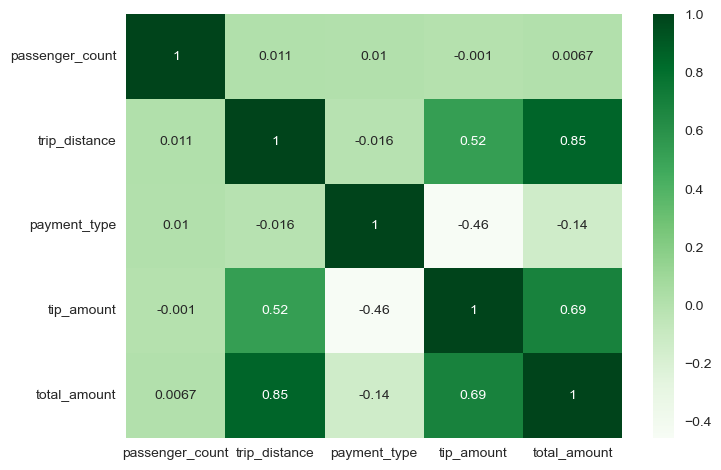

In [30]:
plt.style.use('seaborn')

# plt.figure(figsize=(16,5))  
sns.heatmap(corr_matrix_df,
           xticklabels=corr_matrix_df.columns.values,
           yticklabels=corr_matrix_df.columns.values,  cmap="Greens", annot=True)
plt.show();

### Выводы
- Влияние количества пассажиров на чаевые крайне мало (можно пренебречь)
- Влияние расстояния на чаевые значительно
- На чаевые больше всего оказывает влияние общая сумма оплаты
- Так же на чаевые существенно влияет тип оплаты
- Самая существенная зависимость стоимости оплаты от расстояния


### Графики, как пройденное расстояние и количество пассажиров влияет на чаевые

In [52]:
df_pair = df_graph.toPandas()

<Axes: xlabel='trip_distance', ylabel='tip_amount'>

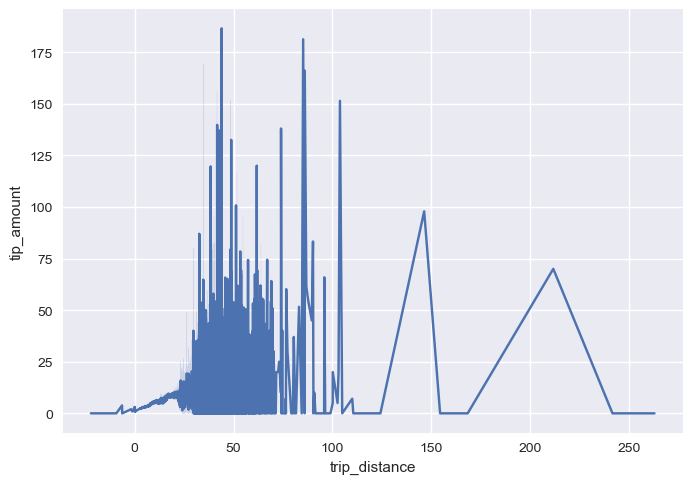

In [53]:
# Чаевые от расстояния
sns.lineplot(
    x="trip_distance", 
    y="tip_amount",
    data=df_pair)

<Axes: xlabel='passenger_count', ylabel='tip_amount'>

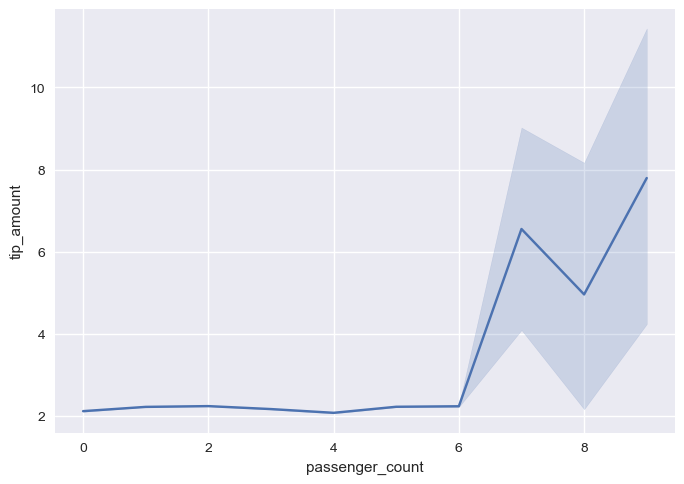

In [54]:
# Чаевые от кол-ва пассажиров
sns.lineplot(
    x="passenger_count", 
    y="tip_amount",
    data=df_pair)

### Вывод по графикам
- чаевые резко возрастают при количестве пассажиров более 6  
(что составляеет крайне малую часть набора данных)
- Влияние расстояния на чаевые значительно: от 25 до 110 миль средние чаевые значительно выше) 
